In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay
from ppu.generator import GaussianBlobs, Circular, Moons, RingBlobs

import gpytorch
import random
import torch
import pyro
import torch.nn.functional as F
from dataset import get_dataset
from utils import BI_LSE, accuracy, get_datasets, stable_logit_transform
from models import MLP
from copy import deepcopy
from scipy.special import expit
import seaborn as sns
from sklearn.inspection._plot.decision_boundary import _check_boundary_response_method

from threadpoolctl import threadpool_limits

import os
os.makedirs('plots', exist_ok=True)

/Users/hb70ur/.pyenv/versions/3.10.4/envs/PPU/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_BI(xs, models):
    preds = np.array([_check_boundary_response_method(m, 'auto')(xs) for m in models])
    # preds might be probabilities
    if len(preds.shape) == 3:
        logits = stable_logit_transform(preds[:,:,1])
    # or just logits
    else:
        logits = preds
        
    BIs = np.array([BI_LSE(zs, bound='lower') for zs in logits.T])
    return BIs

def get_models(clf, gen, reps, n_samples=200, **kwargs):
    result = []
    for rng in range(reps):
        (X_train, y_train), (X_test, y_test) = get_dataset(rng, gen, n_samples=n_samples, **kwargs)
        new_clf = deepcopy(clf)
        new_clf.fit(X_train, y_train)
        result.append(new_clf)
    return result

def nn_models(gen, n_models, n_samples=500, DE=False, extra_kwargs={}, **kwargs):
    result = []
    # if we want deep ensembles, we have to fix the dataset seed to get the same dataset
    seeds = [0 for _ in range(n_models)] if DE else range(n_models)
    
    for rng in seeds:
        (X_train, y_train), (X_test, y_test) = get_dataset(rng, gen, n_samples=n_samples, **extra_kwargs)
        model = MLP(**kwargs)
        model.fit(X_train, y_train)
        result.append(model)
    return result

def BS_models(clf, gen, reps, n_samples=500, **kwargs):
    result = []
    seeds = range(reps)
    (X_train, y_train), (X_test, y_test) = get_dataset(0, gen, n_samples=n_samples, **kwargs)
    for _ in seeds:
        bs_ind = random.choices(range(n_samples), k=n_samples)
        bs_X = X_train[bs_ind]
        bs_y = y_train[bs_ind]
        model = deepcopy(clf)
        model.fit(bs_X, bs_y)
        result.append(model)
    return result

def BS_nn_models(gen, n_models, n_samples=500, DE=False, extra_kwargs={}, **kwargs):

    # bootstrapping
    result = []
    seeds = range(n_models)
    
    (X_train, y_train), (X_test, y_test) = get_dataset(0, gen, n_samples=n_samples, **extra_kwargs)
    for _ in seeds:
        bs_ind = random.choices(range(n_samples), k=n_samples)
        bs_X = X_train[bs_ind]
        bs_y = y_train[bs_ind]
        model = MLP(**kwargs)
        model.fit(bs_X, bs_y)
        result.append(model)
    return result

In [3]:
names = [
    "5 Nearest Neighbors",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "XGBoost",
    "Naive Bayes",
    "Neural Net"
]

classifiers = [
    KNeighborsClassifier(5),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=10),
    GradientBoostingClassifier(n_estimators=10),
    GaussianNB(),
    MLP(hidden_channels=[30, 100, 50, 1], weight_decay=0., patience=20, frequency=2)
]

n_ticks = 100
n_samples = 500  #train instances
reps = 64 # train set sample

In [4]:
from ppu.methods.bregman import *
generator = {
    'GaussianBlobs' : GaussianBlobs,
    'Circular' : Circular,
    'Moons' : Moons,
    'RingBlobs' : RingBlobs
}
id = 1
gen = list(generator.values())[id]
with threadpool_limits(limits=1):
    models = {name: get_models(func, gen, reps=reps, n_samples=n_samples) for name, func in zip(names, classifiers)}
# models['Neural Net'] = nn_models(gen, n_models=reps, n_samples=n_samples, hidden_channels=[30, 100, 50, 1], frequency=2, patience=20)

In [5]:
models.keys()


dict_keys(['5 Nearest Neighbors', 'RBF SVM', 'Gaussian Process', 'Decision Tree', 'Random Forest', 'XGBoost', 'Naive Bayes', 'Neural Net'])

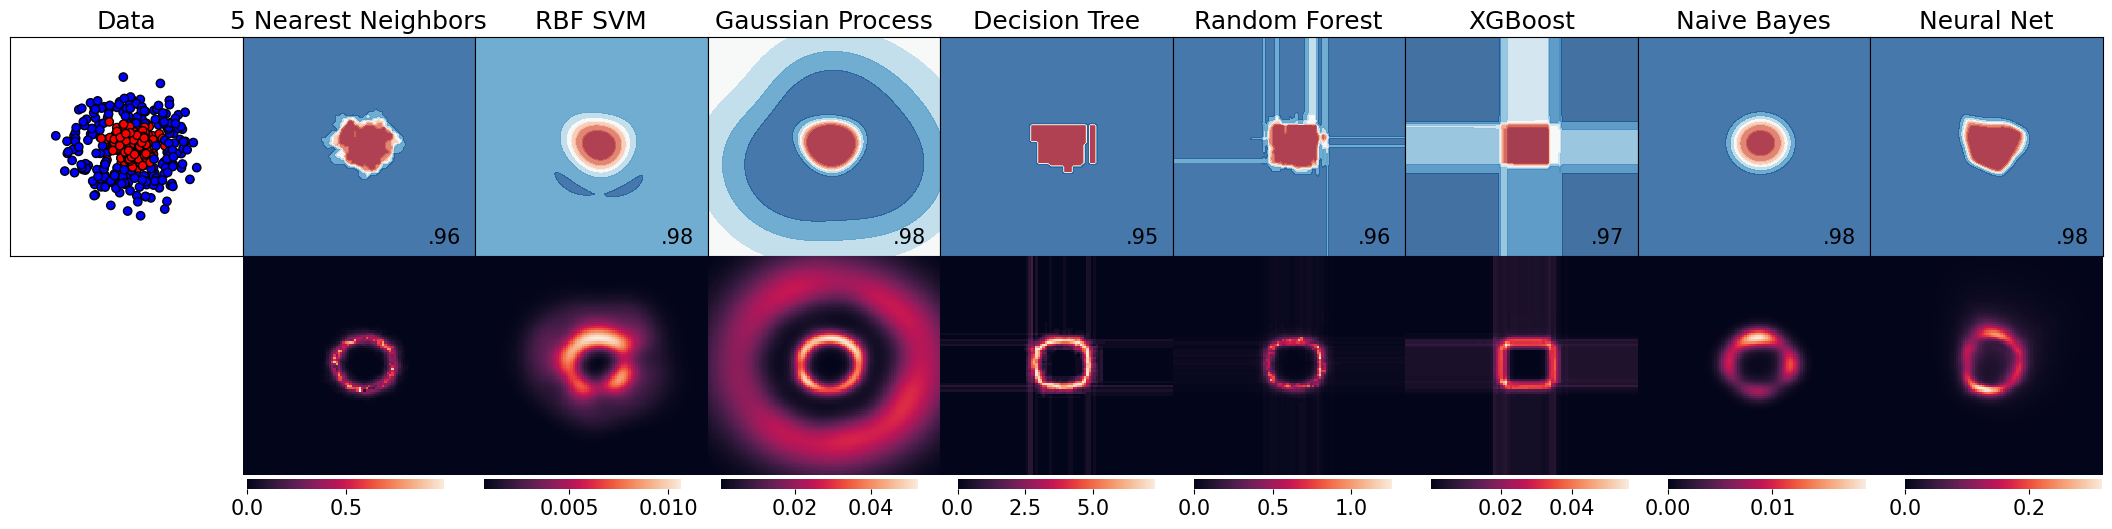

In [6]:
from ppu.methods.bregman import *

figure = diff_classifier(gen, n_samples, names, classifiers, models, rescale = False)

In [7]:
figure.savefig('plots/ext_classifier_ds{}_{}_{}.png'.format(n_samples, list(generator.keys())[id], 'rescale') if False else 'plots/ext_classifier_ds{}_{}.png'.format(n_samples, list(generator.keys())[id]), bbox_inches='tight')

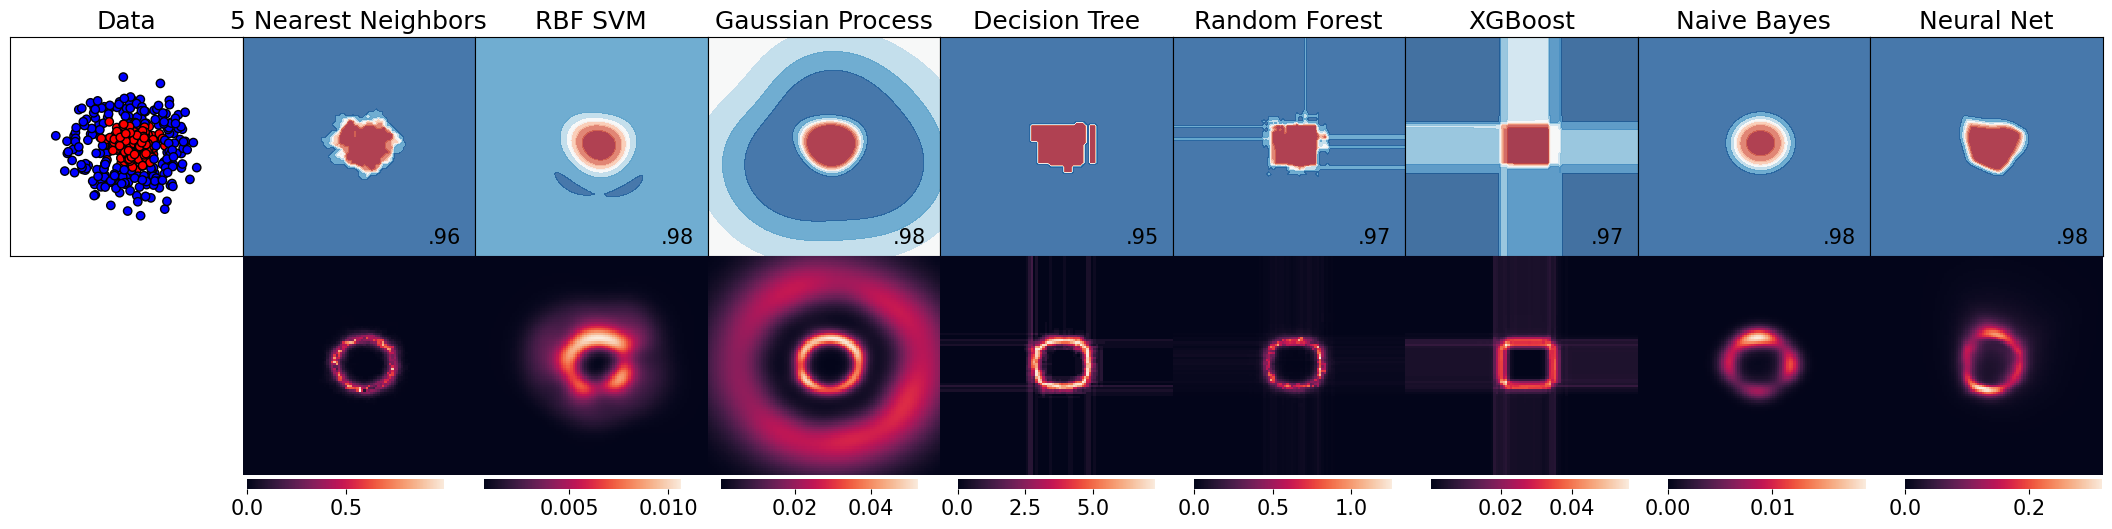

In [8]:
dataset = get_dataset(1000, gen, n_samples=n_samples)
offset = 1
zoom_out = False # True or False means 0 or 1
rows = 2 + zoom_out

rescale = False

gridspec_kw={'height_ratios': [1, 1]}
cbar_kws = dict(use_gridspec=False, location="bottom")
plt.rcParams.update({'font.size': 15})
figure, axs = plt.subplots(rows, len(models) + offset, gridspec_kw=gridspec_kw, figsize=(27, 6+zoom_out*6))

i = 0
eps = 1
n_ticks = 100

ds = dataset
(X_train, y_train), (X_test, y_test) = ds # X is the data point, y is the class label

# the area we draw is a bit larger than the range of data points
x_min, x_max = X_train[:, 0].min() - eps, X_train[:, 0].max() + eps
y_min, y_max = X_train[:, 1].min() - eps, X_train[:, 1].max() + eps

# just plot the dataset first
cm = plt.cm.RdBu # color map parameter
cm_bright = ListedColormap(["#FF0000", "#0000FF"]) # color for data points 
ax = axs[0][i] # position of subgraph
ax.set_title("Data") # subgraph title
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
ax.set_xlim(x_min, x_max) # axis range
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())
i += 1

# iterate over classifiers
for name, clf in zip(names, classifiers):
    ax = axs[0][i]
    clf.fit(X_train, y_train) # clf is the method in classifiers
    score = clf.score(X_test, y_test) # score of the result
    x = np.linspace(x_min, x_max, n_ticks) # for the heatmap we need to creat the grid first, so n_ticks are the density of the grid nodes
    y = np.linspace(y_min, y_max, n_ticks)
    xs, ys = np.meshgrid(x, y)
    X_grid = np.c_[xs.ravel(), ys.ravel()] # All the grid points

    if name == 'Neural Net':
        response = clf.predict(X_grid)
    else: # this if else is no needed
        response = _check_boundary_response_method(clf, 'auto')(X_grid) # the function returns the probability of points(inputs) belong to each class

    if len(response.shape) == 1:
        response = expit(response)
    else:
        response = response[:, 1] # since there's only 2 classes so 1 can represent the other(the prob sums up to 1) 

    display = DecisionBoundaryDisplay(
        xx0=xs,
        xx1=ys,
        response=response.reshape(xs.shape),
    ) # class to draw DecisionBoundary
    display.plot(ax=ax, cmap=cm, alpha=0.8) # alpha controls the transparency of the filled contours

    ax.set_xticks(()) # remove the ticks
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(
        x_max - 0.3,
        y_min + 0.3,
        ("%.2f" % score).lstrip("0"),
        horizontalalignment="right",
    ) # score as text on the right bottom of the subgraph
    i += 1
# draw NN graph as NN is not in list names
'''name = 'Neural Net'
ax = axs[0][i]
ax.set_title(name)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())

torch.manual_seed(1000)
model = MLP(hidden_channels=[30, 100, 50, 1], weight_decay=0., patience=20, frequency=2)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
x = np.linspace(x_min, x_max, n_ticks)
y = np.linspace(y_min, y_max, n_ticks)
xs, ys = np.meshgrid(x, y)
X_grid = np.c_[xs.ravel(), ys.ravel()]

response = model.predict(X_grid)
response = expit(response)

display = DecisionBoundaryDisplay(
    xx0=xs,
    xx1=ys,
    response=response.reshape(xs.shape),
)
display.plot(ax=ax, cmap=cm, alpha=0.8)
ax.set_title(name)
ax.text(
    x_max - 0.3,
    y_min + 0.3,
    ("%.2f" % score).lstrip("0"),
    horizontalalignment="right",
) # text on the graph'''

i = 0
if False: #zoom_out:
    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = axs[1][i]
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
else:
    ax = axs[1][i]
    ax.axis('off') # turn off both x-axis and y-axis, including their labels and ticks

i += 1

x_min, x_max = X_train[:, 0].min() - eps, X_train[:, 0].max() + eps
y_min, y_max = X_train[:, 1].min() - eps, X_train[:, 1].max() + eps

'''vmin = 1
vmax = 0
for name in models.keys():
    ax = axs[1][i]
    x = np.linspace(x_min, x_max, n_ticks)
    y = np.linspace(y_min, y_max, n_ticks)
    xs, ys = np.meshgrid(x, y)
    X_grid = np.c_[xs.ravel(), ys.ravel()] # same as above
    response = get_BI(X_grid, models[name])
    if min(response) < vmin:
        vmin = min(response)
    if max(response) > vmax:
        vmax = max(response)'''

# iterate over classifiers
for name in models.keys():
    ax = axs[1][i]
    x = np.linspace(x_min, x_max, n_ticks)
    y = np.linspace(y_min, y_max, n_ticks)
    xs, ys = np.meshgrid(x, y)
    X_grid = np.c_[xs.ravel(), ys.ravel()] # same as above
    response = get_BI(X_grid, models[name])
    if rescale:
        vmin = min(response)
        vmax = max(response)
        response = (response-vmin) / (vmax-vmin)
    response = response.reshape(xs.shape)

    with np.errstate(all='ignore'):
        sns.heatmap(response, ax=ax, cbar_kws=cbar_kws).invert_yaxis()

    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

i = 0
if zoom_out:
    eps = 5
    x_min, x_max = X_train[:, 0].min() - eps, X_train[:, 0].max() + eps
    y_min, y_max = X_train[:, 1].min() - eps, X_train[:, 1].max() + eps

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = axs[2][i]
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name in models.keys():
        ax = axs[i]
        x = np.linspace(x_min, x_max, n_ticks)
        y = np.linspace(y_min, y_max, n_ticks)
        xs, ys = np.meshgrid(x, y)
        X_grid = np.c_[xs.ravel(), ys.ravel()]
        response = get_BI(X_grid, models[name])
        response = response.reshape(xs.shape)

        with np.errstate(all='ignore'):
            sns.heatmap(response, ax=ax, cbar_kws=cbar_kws).invert_yaxis()

        ax.set_xticks(())
        ax.set_yticks(())
        i += 1

#plt.tight_layout()
plt.subplots_adjust(#left=0.1,
                    bottom=.17,
                    #right=0.9,
                    top=.9,
                    wspace=0.,
                    hspace=0.)
plt.savefig('plots/ext_classifier_ds{}_{}_{}.png'.format(n_samples, list(generator.keys())[id], 'rescale') if rescale else 'plots/ext_classifier_ds{}_{}.png'.format(n_samples, list(generator.keys())[id]), bbox_inches='tight')
plt.show()

In [9]:
bs_models = BS_nn_models(gen, n_models=64, n_samples=n_samples, hidden_channels=[30, 100, 50, 1], frequency=2, patience=25)

In [10]:
# train deep ensemble
de_models = nn_models(gen, n_models=64, n_samples=n_samples, hidden_channels=[30, 100, 50, 1], frequency=2, patience=25, DE=True)

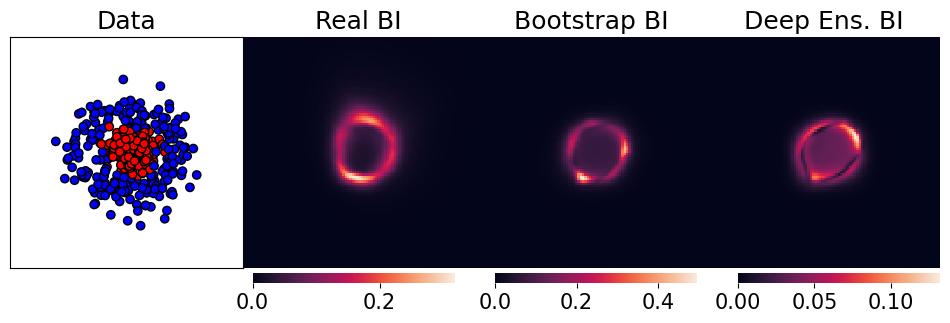

In [11]:
# Figure 6
dataset = get_dataset(1000, gen, n_samples=n_samples)
zoom_out = False

cbar_kws = dict(use_gridspec=False, location="bottom")
plt.rcParams.update({'font.size': 15})
figure, axs = plt.subplots(1, 4, figsize=(12, 3.5))
eps = 1
n_ticks = 100

ds = dataset
(X_train, y_train), (X_test, y_test) = ds

x_min, x_max = X_train[:, 0].min() - eps, X_train[:, 0].max() + eps
y_min, y_max = X_train[:, 1].min() - eps, X_train[:, 1].max() + eps

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
ax = axs[0]
ax.set_title("Data")
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())

name = 'Neural Net'
x = np.linspace(x_min, x_max, n_ticks)
y = np.linspace(y_min, y_max, n_ticks)
xs, ys = np.meshgrid(x, y)
X_grid = np.c_[xs.ravel(), ys.ravel()]

# Real BI (approx over training set samples
response = get_BI(X_grid, models[name])
response = response.reshape(xs.shape)

ax = axs[1]
with np.errstate(all='ignore'):
    sns.heatmap(response, ax=ax, cbar_kws=cbar_kws).invert_yaxis()

ax.set_title('Real BI')
ax.set_xticks(())
ax.set_yticks(())

# BI bootstrap
response = get_BI(X_grid, bs_models)
response = response.reshape(xs.shape)

ax = axs[2]
with np.errstate(all='ignore'):
    sns.heatmap(response, ax=ax, cbar_kws=cbar_kws).invert_yaxis()

ax.set_title('Bootstrap BI')
ax.set_xticks(())
ax.set_yticks(())

# BI deep ensembles
response = get_BI(X_grid, de_models)
response = response.reshape(xs.shape)

ax = axs[3]
with np.errstate(all='ignore'):
    sns.heatmap(response, ax=ax, cbar_kws=cbar_kws).invert_yaxis()

ax.set_title('Deep Ens. BI')
ax.set_xticks(())
ax.set_yticks(())

#plt.tight_layout()
plt.subplots_adjust(#left=0.1,
                    bottom=.24,
                    #right=0.9,
                    top=.9,
                    wspace=0.,
                    hspace=0.)
plt.savefig('plots/BI_approx_ds{}_{}.png'.format(n_samples, list(generator.keys())[id]), bbox_inches='tight')
plt.show()

In [12]:
model_selected = [
    "5 Nearest Neighbors",
    "Gaussian Process",
    "XGBoost",
    "Neural Net"
]
selected_models = {k: models[k] for k in model_selected if k in models}
selected_models.keys()


dict_keys(['5 Nearest Neighbors', 'Gaussian Process', 'XGBoost', 'Neural Net'])

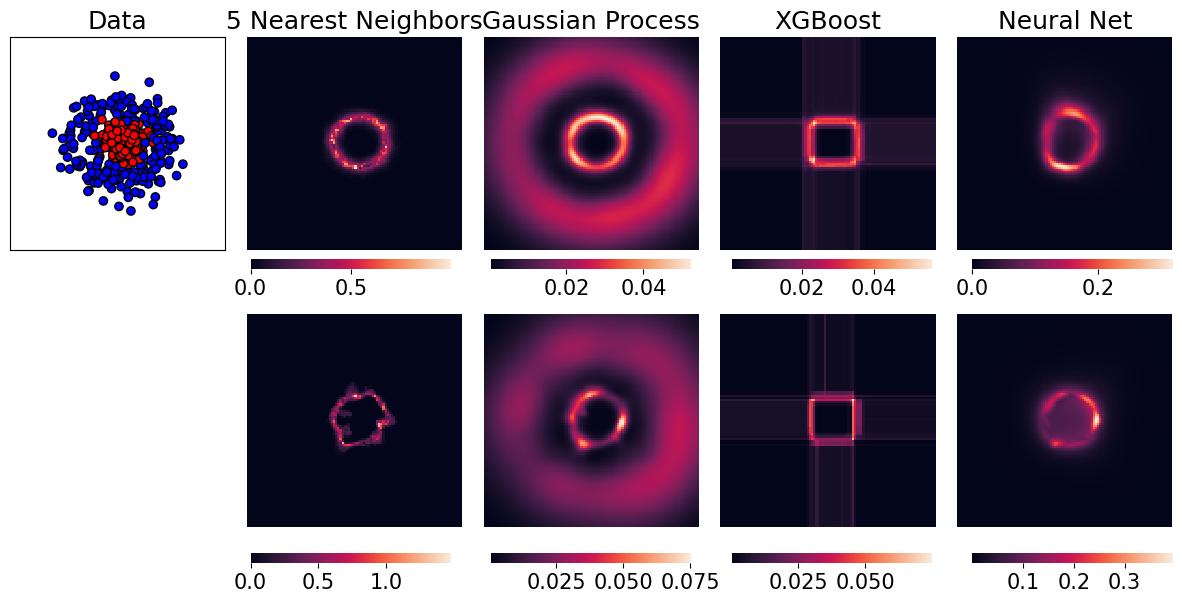

In [13]:
dataset = get_dataset(1000, gen, n_samples=n_samples)
gridspec_kw={'height_ratios': [1, 1]}
cbar_kws = dict(use_gridspec=False, location="bottom")
plt.rcParams.update({'font.size': 15})
figure, axs = plt.subplots(2, 5, figsize=(15, 7))


i = 0
eps = 1
n_ticks = 100

ds = dataset
(X_train, y_train), (X_test, y_test) = ds # X is the data point, y is the class label

# the area we draw is a bit larger than the range of data points
x_min, x_max = X_train[:, 0].min() - eps, X_train[:, 0].max() + eps
y_min, y_max = X_train[:, 1].min() - eps, X_train[:, 1].max() + eps

# just plot the dataset first
cm = plt.cm.RdBu # color map parameter
cm_bright = ListedColormap(["#FF0000", "#0000FF"]) # color for data points 
ax = axs[0][i] # position of subgraph
ax.set_title("Data") # subgraph title
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
ax.set_xlim(x_min, x_max) # axis range
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())
i += 1

for name in selected_models.keys():
    ax = axs[0][i]
    ax.set_title(name)
    x = np.linspace(x_min, x_max, n_ticks)
    y = np.linspace(y_min, y_max, n_ticks)
    xs, ys = np.meshgrid(x, y)
    X_grid = np.c_[xs.ravel(), ys.ravel()] # same as above
    response = get_BI(X_grid, models[name])
    if rescale:
        vmin = min(response)
        vmax = max(response)
        response = (response-vmin) / (vmax-vmin)
    response = response.reshape(xs.shape)

    with np.errstate(all='ignore'):
        sns.heatmap(response, ax=ax, cbar_kws=cbar_kws).invert_yaxis()

    ax.set_xticks(())
    ax.set_yticks(())
    i += 1


i = 0
ax = axs[1][i]
ax.axis('off')
i += 1

for name in selected_models.keys():
    x = np.linspace(x_min, x_max, n_ticks)
    y = np.linspace(y_min, y_max, n_ticks)
    xs, ys = np.meshgrid(x, y)
    X_grid = np.c_[xs.ravel(), ys.ravel()]

    if name == 'Neural Net':
        response = get_BI(X_grid, BS_nn_models(gen, n_models=64, n_samples=n_samples, hidden_channels=[30, 100, 50, 1], frequency=2, patience=25))
    else:
        with threadpool_limits(limits=1):
            response = get_BI(X_grid, BS_models(dict(zip(names, classifiers))[name], gen, reps=64, n_samples=n_samples))
    response = response.reshape(xs.shape)
    ax = axs[1][i]

    with np.errstate(all='ignore'):
        sns.heatmap(response, ax=ax, cbar_kws=cbar_kws).invert_yaxis()

    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

plt.subplots_adjust(#left=0.1,
                    bottom=.2,
                    #right=0.9,
                    top=.9,
                    wspace=0.1,
                    hspace=0.3)
plt.savefig('plots/BI_bBI_ds{}_{}.png'.format(n_samples, list(generator.keys())[id]), bbox_inches='tight')
plt.show()

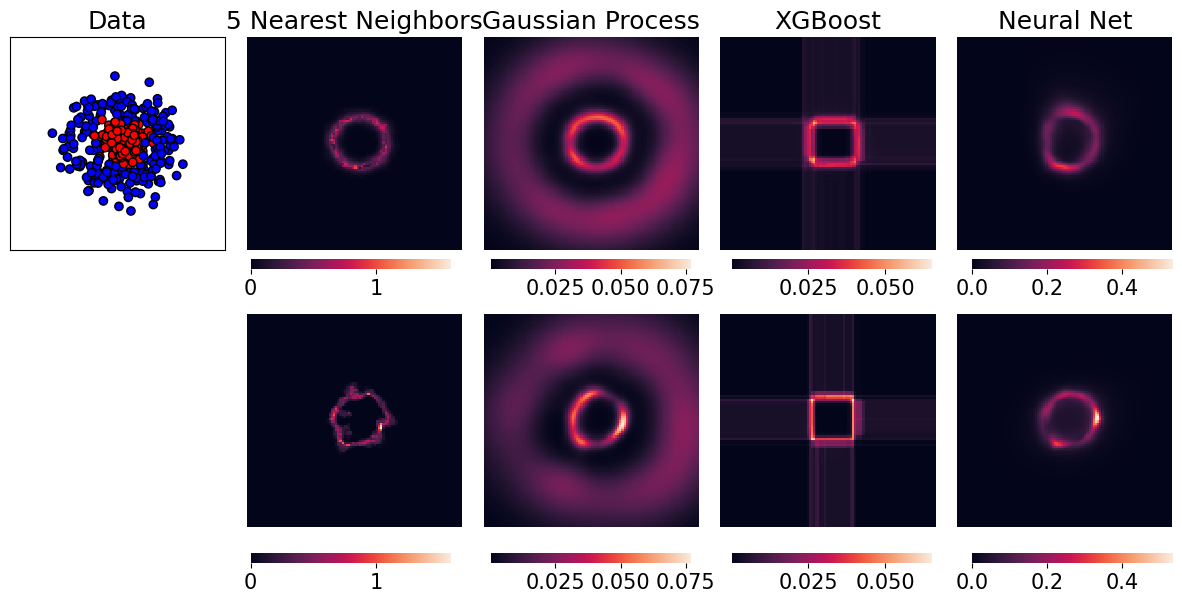

In [14]:
dataset = get_dataset(1000, gen, n_samples=n_samples)
gridspec_kw={'height_ratios': [1, 1]}
cbar_kws = dict(use_gridspec=False, location="bottom")
plt.rcParams.update({'font.size': 15})
figure, axs = plt.subplots(2, 5, figsize=(15, 7))


i = 0
eps = 1
n_ticks = 100

ds = dataset
(X_train, y_train), (X_test, y_test) = ds # X is the data point, y is the class label

# the area we draw is a bit larger than the range of data points
x_min, x_max = X_train[:, 0].min() - eps, X_train[:, 0].max() + eps
y_min, y_max = X_train[:, 1].min() - eps, X_train[:, 1].max() + eps

# just plot the dataset first
cm = plt.cm.RdBu # color map parameter
cm_bright = ListedColormap(["#FF0000", "#0000FF"]) # color for data points 
ax = axs[0][i] # position of subgraph
ax.set_title("Data") # subgraph title
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
ax.set_xlim(x_min, x_max) # axis range
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())
i += 1

ax = axs[1][0]
ax.axis('off')

for name in selected_models.keys():
    
    
    x = np.linspace(x_min, x_max, n_ticks)
    y = np.linspace(y_min, y_max, n_ticks)
    xs, ys = np.meshgrid(x, y)
    X_grid = np.c_[xs.ravel(), ys.ravel()]
    response1 = get_BI(X_grid, models[name])
    vmin = min(response1)
    vmax = max(response1)
    response1 = response1.reshape(xs.shape)

    
    if name == 'Neural Net':
        response2 = get_BI(X_grid, BS_nn_models(gen, n_models=64, n_samples=n_samples, hidden_channels=[30, 100, 50, 1], frequency=2, patience=25))
    else:
        with  threadpool_limits(limits=1):
            response2 = get_BI(X_grid, BS_models(dict(zip(names, classifiers))[name], gen, reps=64, n_samples=n_samples))
    vmin = min(vmin, min(response2))
    vmax = max(vmax, max(response2))
    response2 = response2.reshape(xs.shape)

    ax = axs[0][i]
    ax.set_title(name)
    with np.errstate(all='ignore'):
        sns.heatmap(response1, ax=ax, vmin=vmin, vmax=vmax, cbar_kws=cbar_kws).invert_yaxis()

    ax.set_xticks(())
    ax.set_yticks(())


    ax = axs[1][i]

    with np.errstate(all='ignore'):
        sns.heatmap(response2, ax=ax, vmin=vmin, vmax=vmax, cbar_kws=cbar_kws).invert_yaxis()

    ax.set_xticks(())
    ax.set_yticks(())

    i += 1


plt.subplots_adjust(#left=0.1,
                    bottom=.2,
                    #right=0.9,
                    top=.9,
                    wspace=0.1,
                    hspace=0.3)
plt.savefig('plots/BI_bBI_ds{}_{}.png'.format(n_samples, list(generator.keys())[id]), bbox_inches='tight')
plt.show()

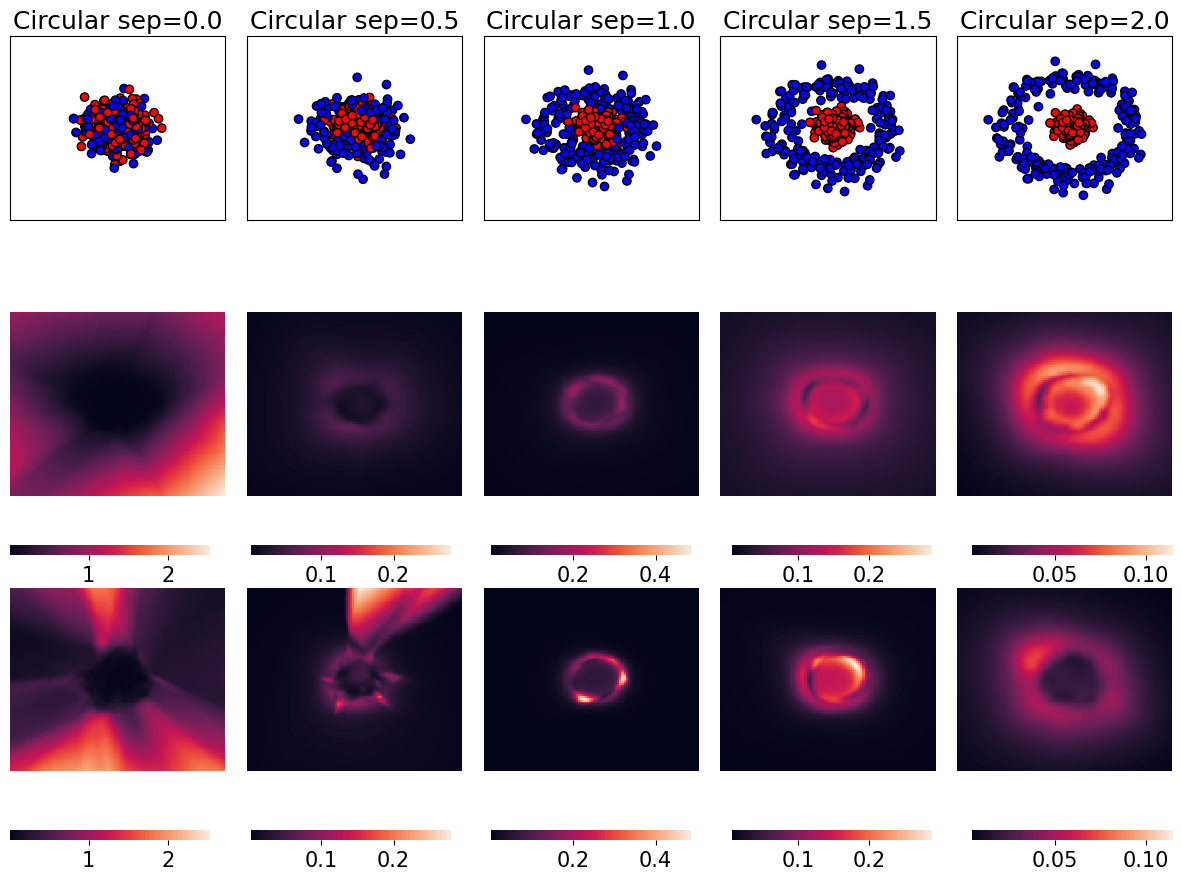

In [15]:
'''
different class_sep
'''

name = 'Neural Net'
if name != 'Neural Net':
    func = dict(zip(names, classifiers))[name]
name_gen = 'Circular'
gen = generator[name_gen]
gridspec_kw={'height_ratios': [1, 1]}
cbar_kws = dict(use_gridspec=False, location="bottom")
plt.rcParams.update({'font.size': 15})
figure, axs = plt.subplots(3, 5, figsize=(15, 10.5))
reps = 64

i = 0
eps = 1
n_ticks = 100


sep = [0.5 * i for i in range(5)]


for i in range(5):
    dataset = get_dataset(1000, gen, n_samples=n_samples, class_sep=sep[i])
    ds = dataset

    (X_train, y_train), (X_test, y_test) = ds # X is the data point, y is the class label

    if name == "Neural Net":
        sep_model = nn_models(gen, n_models=reps, n_samples=n_samples, extra_kwargs={'class_sep':sep[i]}, hidden_channels=[30, 100, 50, 1], frequency=2, patience=20)
    else:
        with threadpool_limits(limits=1):
            sep_model = get_models(func, gen, reps=reps, n_samples=n_samples, class_sep=sep[i])

    # the area we draw is a bit larger than the range of data points
    x_min, x_max = X_train[:, 0].min() - eps, X_train[:, 0].max() + eps
    y_min, y_max = X_train[:, 1].min() - eps, X_train[:, 1].max() + eps

    cm = plt.cm.RdBu # color map parameter
    cm_bright = ListedColormap(["#FF0000", "#0000FF"]) # color for data points 
    ax = axs[0][i] # position of subgraph
    ax.set_title('{} sep={}'.format(name_gen, sep[i])) # subgraph title
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    ax.set_xlim(x_min, x_max) # axis range
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    
    x = np.linspace(x_min, x_max, n_ticks)
    y = np.linspace(y_min, y_max, n_ticks)
    xs, ys = np.meshgrid(x, y)
    X_grid = np.c_[xs.ravel(), ys.ravel()]
    response1 = get_BI(X_grid, sep_model)
    vmin = min(response1)
    vmax = max(response1)
    response1 = response1.reshape(xs.shape)

    
    if name == 'Neural Net':
        response2 = get_BI(X_grid, BS_nn_models(gen, n_models=reps, n_samples=n_samples, extra_kwargs={'class_sep':sep[i]}, hidden_channels=[30, 100, 50, 1], frequency=2, patience=25))
    else:
        with threadpool_limits(limits=1):
            response2 = get_BI(X_grid, BS_models(func, gen, reps=reps, n_samples=n_samples), class_sep=sep[i])
    vmin = min(vmin, min(response2))
    vmax = max(vmax, max(response2))
    response2 = response2.reshape(xs.shape)

    ax = axs[1][i]
    #ax.set_title()
    with np.errstate(all='ignore'):
        sns.heatmap(response1, ax=ax, vmin=vmin, vmax=vmax, cbar_kws=cbar_kws).invert_yaxis()

    ax.set_xticks(())
    ax.set_yticks(())


    ax = axs[2][i]

    with np.errstate(all='ignore'):
        sns.heatmap(response2, ax=ax, vmin=vmin, vmax=vmax, cbar_kws=cbar_kws).invert_yaxis()

    ax.set_xticks(())
    ax.set_yticks(())

    i += 1


plt.subplots_adjust(#left=0.1,
                    bottom=.2,
                    #right=0.9,
                    top=.9,
                    wspace=0.1,
                    hspace=0.5)
plt.savefig('plots/BI_bBI_classsep_ds{}_{}_{}.png'.format(n_samples, gen, name), bbox_inches='tight')
plt.show()

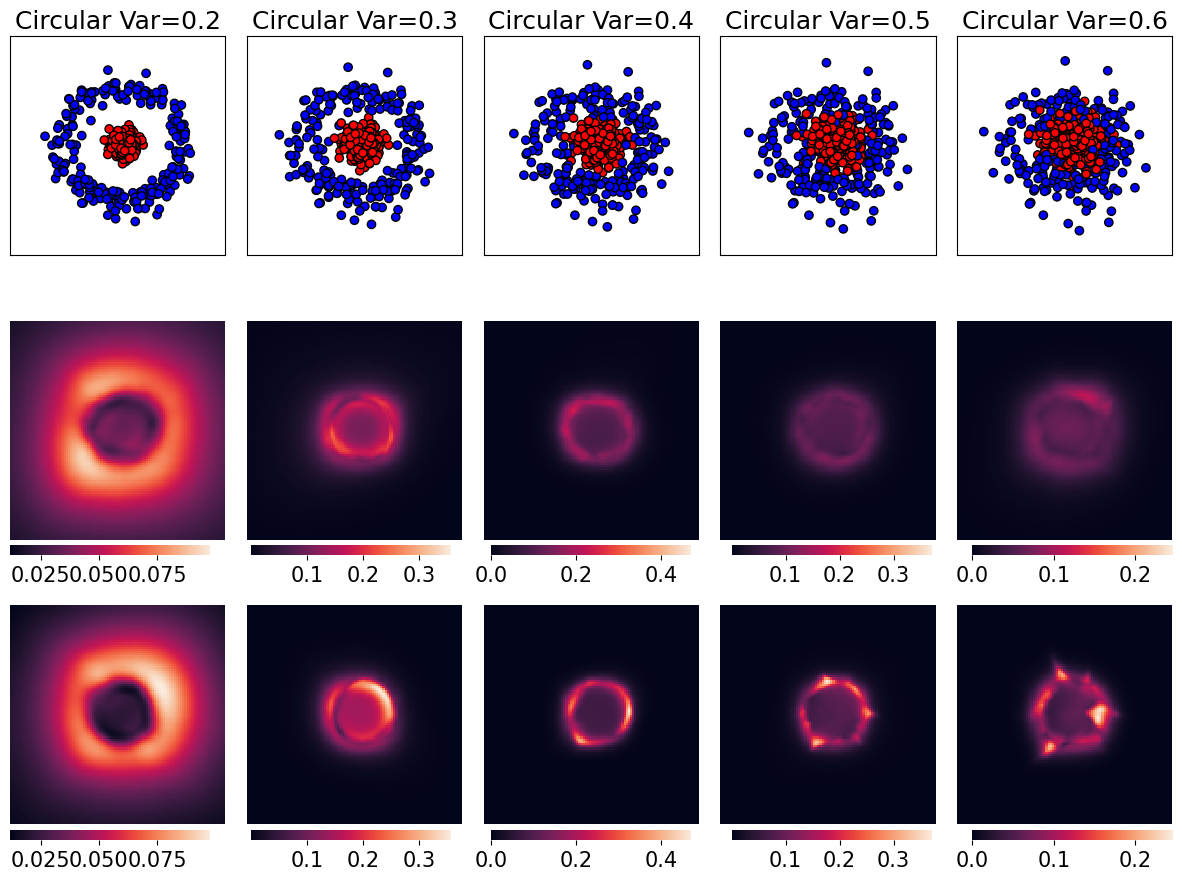

In [16]:
'''
different variance
'''

name = 'Neural Net'
if name != 'Neural Net':
    func = dict(zip(names, classifiers))[name]
name_gen = 'Circular'
gen = generator[name_gen]
gridspec_kw={'height_ratios': [1, 1]}
cbar_kws = dict(use_gridspec=False, location="bottom")
plt.rcParams.update({'font.size': 15})
figure, axs = plt.subplots(3, 5, figsize=(15, 10.5))
reps = 64

i = 0
eps = 1
n_ticks = 100


v = [0.2, 0.3, 0.4, 0.5, 0.6]


for i in range(5):
    dataset = get_dataset(1000, gen, n_samples=n_samples, scale=(v[i], v[i]), class_sep=1.7)
    ds = dataset

    (X_train, y_train), (X_test, y_test) = ds # X is the data point, y is the class label

    if name == "Neural Net":
        sep_model = nn_models(gen, n_models=reps, n_samples=n_samples, extra_kwargs={'class_sep':1.7, 'scale':(v[i], v[i])}, hidden_channels=[30, 100, 50, 1], frequency=2, patience=20)
    else:
        sep_model = get_models(func, gen, reps=reps, n_samples=n_samples, scale=(v[i], v[i]), class_sep=1.7)

    # the area we draw is a bit larger than the range of data points
    x_min, x_max = X_train[:, 0].min() - eps, X_train[:, 0].max() + eps
    y_min, y_max = X_train[:, 1].min() - eps, X_train[:, 1].max() + eps

    cm = plt.cm.RdBu # color map parameter
    cm_bright = ListedColormap(["#FF0000", "#0000FF"]) # color for data points 
    ax = axs[0][i] # position of subgraph
    ax.set_title('{} Var={}'.format(name_gen, v[i])) # subgraph title
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    ax.set_xlim(x_min, x_max) # axis range
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    
    x = np.linspace(x_min, x_max, n_ticks)
    y = np.linspace(y_min, y_max, n_ticks)
    xs, ys = np.meshgrid(x, y)
    X_grid = np.c_[xs.ravel(), ys.ravel()]
    response1 = get_BI(X_grid, sep_model)
    vmin = min(response1)
    vmax = max(response1)
    response1 = response1.reshape(xs.shape)

    
    if name == 'Neural Net':
        response2 = get_BI(X_grid, BS_nn_models(gen, n_models=reps, n_samples=n_samples, extra_kwargs={'class_sep':1.7, 'scale':(v[i], v[i])}, hidden_channels=[30, 100, 50, 1], frequency=2, patience=25))
    else:
        response2 = get_BI(X_grid, BS_models(func, gen, reps=reps, n_samples=n_samples, scale=(v[i], v[i]), class_sep=1.7))
    vmin = min(vmin, min(response2))
    vmax = max(vmax, max(response2))
    response2 = response2.reshape(xs.shape)

    ax = axs[1][i]
    #ax.set_title()
    with np.errstate(all='ignore'):
        sns.heatmap(response1, ax=ax, vmin=vmin, vmax=vmax, cbar_kws=cbar_kws).invert_yaxis()

    ax.set_xticks(())
    ax.set_yticks(())


    ax = axs[2][i]

    with np.errstate(all='ignore'):
        sns.heatmap(response2, ax=ax, vmin=vmin, vmax=vmax, cbar_kws=cbar_kws).invert_yaxis()

    ax.set_xticks(())
    ax.set_yticks(())

    i += 1


plt.subplots_adjust(#left=0.1,
                    bottom=.15,
                    #right=0.9,
                    top=.9,
                    wspace=0.1,
                    hspace=0.3)
plt.savefig('plots/BI_bBI_variance_ds{}_{}_{}.png'.format(n_samples, gen, name), bbox_inches='tight')
plt.show()

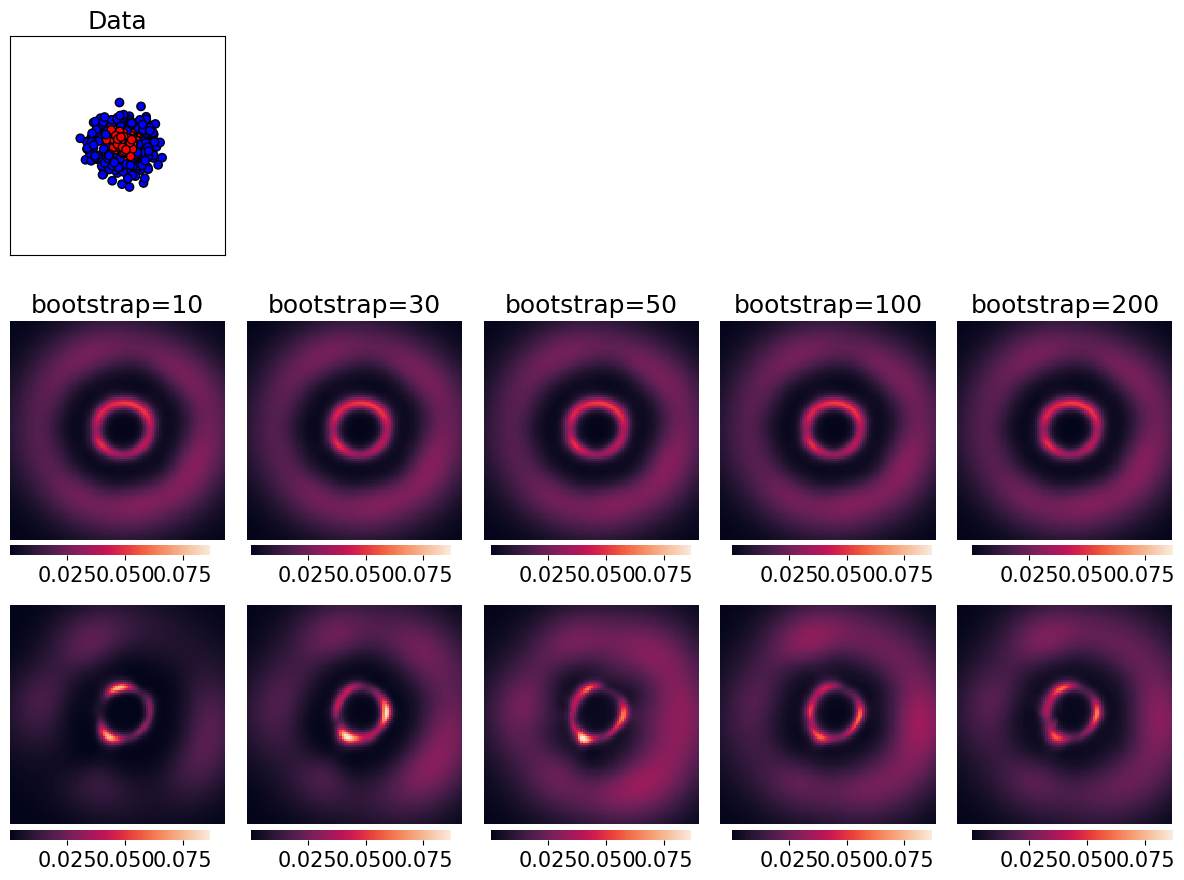

In [17]:
'''
Bootstrap
'''

name = 'Gaussian Process'
if name != 'Neural Net':
    func = dict(zip(names, classifiers))[name]
name_gen = 'Circular'
gen = generator[name_gen]
gridspec_kw={'height_ratios': [1, 1]}
cbar_kws = dict(use_gridspec=False, location="bottom")
plt.rcParams.update({'font.size': 15})

bootstrap = [10, 30, 50, 100, 200]
num = len(bootstrap)
figure, axs = plt.subplots(3, num, figsize=(3*num, 10.5))
reps = 64

i = 0
eps = 1
n_ticks = 100


dataset = get_dataset(1000, gen, n_samples=n_samples)
ds = dataset
(X_train, y_train), (X_test, y_test) = ds # X is the data point, y is the class label

cm = plt.cm.RdBu # color map parameter
cm_bright = ListedColormap(["#FF0000", "#0000FF"]) # color for data points 
ax = axs[0][i] # position of subgraph
ax.set_title('Data') # subgraph title
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
ax.set_xlim(x_min, x_max) # axis range
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())

for i in range(1,num):
    ax = axs[0][i]
    ax.axis('off')

if name == "Neural Net":
    sep_model = nn_models(gen, n_models=reps, n_samples=n_samples, hidden_channels=[30, 100, 50, 1], frequency=2, patience=20)
else:
    with threadpool_limits(limits=1):
        sep_model = get_models(func, gen, reps=reps, n_samples=n_samples)

# the area we draw is a bit larger than the range of data points
x_min, x_max = X_train[:, 0].min() - eps, X_train[:, 0].max() + eps
y_min, y_max = X_train[:, 1].min() - eps, X_train[:, 1].max() + eps

    
    
x = np.linspace(x_min, x_max, n_ticks)
y = np.linspace(y_min, y_max, n_ticks)
xs, ys = np.meshgrid(x, y)
X_grid = np.c_[xs.ravel(), ys.ravel()]
response1 = get_BI(X_grid, sep_model)
vmin = min(response1)
vmax = max(response1)
response1 = response1.reshape(xs.shape)

response2 = [None for j in range(num)]
for i in range(num):
    if name == 'Neural Net':
        response2[i] = get_BI(X_grid, BS_nn_models(gen, n_models=bootstrap[i], n_samples=n_samples, hidden_channels=[30, 100, 50, 1], frequency=2, patience=25))
    else:
        with threadpool_limits(limits=1):
            response2[i] = get_BI(X_grid, BS_models(func, gen, reps=bootstrap[i]))
    vmin = min(vmin, min(response2[i]))
    vmax = max(vmax, max(response2[i]))
    response2[i] = response2[i].reshape(xs.shape)

for i in range(num):
    ax = axs[1][i]
    ax.set_title('bootstrap={}'.format(bootstrap[i]))
    with np.errstate(all='ignore'):
        sns.heatmap(response1, ax=ax, vmin=vmin, vmax=vmax, cbar_kws=cbar_kws).invert_yaxis()

    ax.set_xticks(())
    ax.set_yticks(())


    ax = axs[2][i]

    with np.errstate(all='ignore'):
        sns.heatmap(response2[i], ax=ax, vmin=vmin, vmax=vmax, cbar_kws=cbar_kws).invert_yaxis()

    ax.set_xticks(())
    ax.set_yticks(())



plt.subplots_adjust(#left=0.1,
                    bottom=.15,
                    #right=0.9,
                    top=.9,
                    wspace=0.1,
                    hspace=0.3)
plt.savefig('plots/BI_bBI_bootstrap_ds{}_{}_{}.png'.format(n_samples, name_gen, name), bbox_inches='tight')
plt.show()

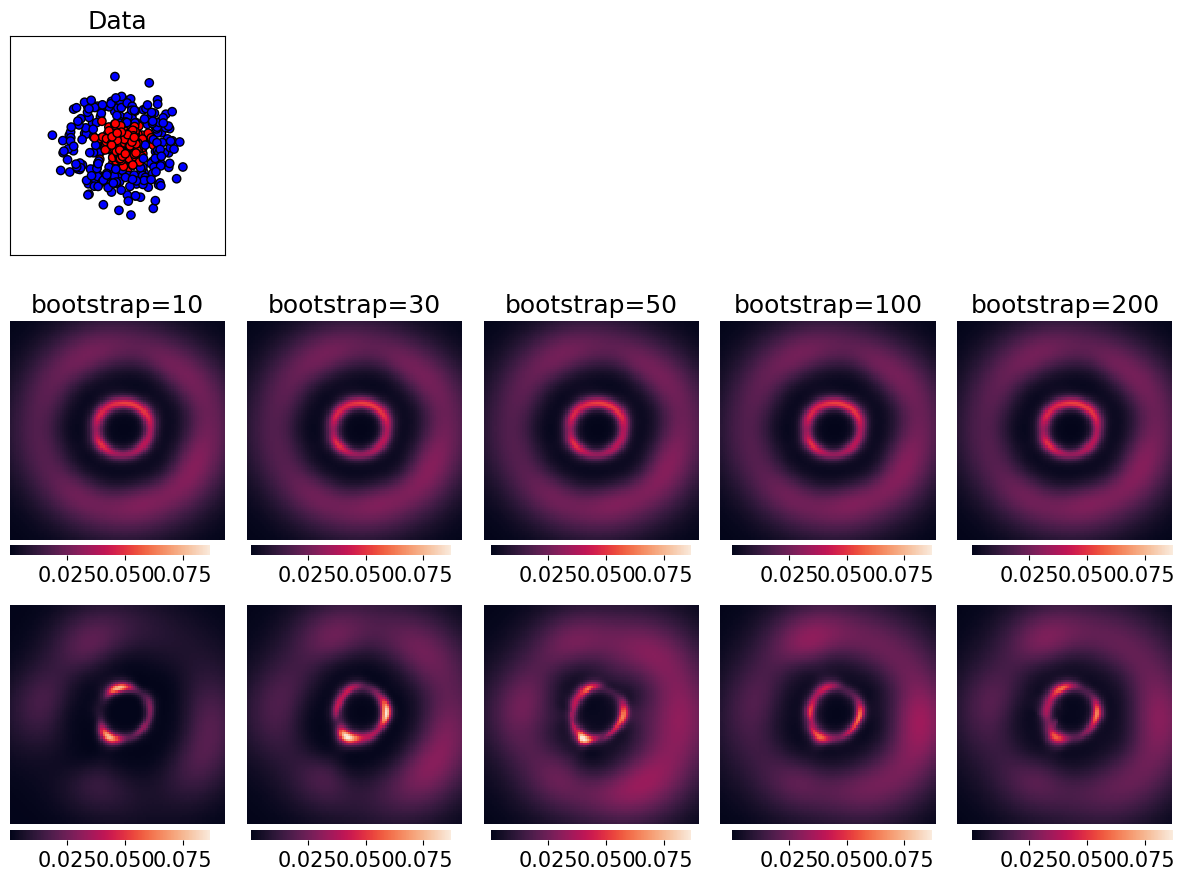

In [18]:
figure, axs = plt.subplots(3, num, figsize=(3*num, 10.5))

dataset = get_dataset(1000, gen, n_samples=n_samples)
ds = dataset
(X_train, y_train), (X_test, y_test) = ds # X is the data point, y is the class label

cm = plt.cm.RdBu # color map parameter
cm_bright = ListedColormap(["#FF0000", "#0000FF"]) # color for data points 
ax = axs[0][0] # position of subgraph
ax.set_title('Data') # subgraph title
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
ax.set_xlim(x_min, x_max) # axis range
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())

for i in range(1,num):
    ax = axs[0][i]
    ax.axis('off')



for i in range(num):
    ax = axs[1][i]
    ax.set_title('bootstrap={}'.format(bootstrap[i]))
    with np.errstate(all='ignore'):
        sns.heatmap(response1, ax=ax, vmin=vmin, vmax=vmax, cbar_kws=cbar_kws).invert_yaxis()

    ax.set_xticks(())
    ax.set_yticks(())


    ax = axs[2][i]

    with np.errstate(all='ignore'):
        sns.heatmap(response2[i], ax=ax, vmin=vmin, vmax=vmax, cbar_kws=cbar_kws).invert_yaxis()

    ax.set_xticks(())
    ax.set_yticks(())

plt.subplots_adjust(#left=0.1,
                    bottom=.15,
                    #right=0.9,
                    top=.9,
                    wspace=0.1,
                    hspace=0.3)
plt.savefig('plots/BI_bBI_bootstrap_ds{}_{}_{}.png'.format(n_samples, name_gen, name), bbox_inches='tight')
plt.show()

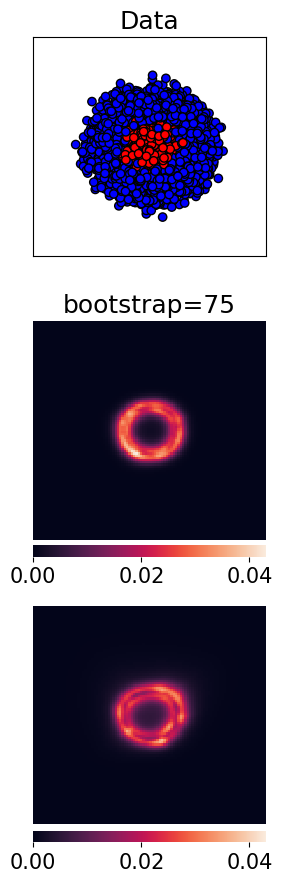

In [19]:
'''
Bootstrap
'''
n_samples = 10000

name = 'Neural Net'
if name != 'Neural Net':
    func = dict(zip(names, classifiers))[name]
name_gen = 'Circular'
gen = generator[name_gen]
gridspec_kw={'height_ratios': [1, 1]}
cbar_kws = dict(use_gridspec=False, location="bottom")
plt.rcParams.update({'font.size': 15})

bootstrap = [75]
num = len(bootstrap)
figure, axs = plt.subplots(3, num, figsize=(3*num, 10.5))
reps = 64

i = 0
eps = 1
n_ticks = 100


dataset = get_dataset(1000, gen, n_samples=n_samples)
ds = dataset
(X_train, y_train), (X_test, y_test) = ds # X is the data point, y is the class label

x_min, x_max = X_train[:, 0].min() - eps, X_train[:, 0].max() + eps
y_min, y_max = X_train[:, 1].min() - eps, X_train[:, 1].max() + eps

cm = plt.cm.RdBu # color map parameter
cm_bright = ListedColormap(["#FF0000", "#0000FF"]) # color for data points 
ax = axs[0] # position of subgraph
ax.set_title('Data') # subgraph title
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
ax.set_xlim(x_min, x_max) # axis range
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())

for i in range(1,num):
    ax = axs[0]
    ax.axis('off')

if name == "Neural Net":
    sep_model = nn_models(gen, n_models=reps, n_samples=n_samples, hidden_channels=[30, 100, 50, 1], frequency=2, patience=20)
else:
    with threadpool_limits(limits=1):
        sep_model = get_models(func, gen, reps=reps, n_samples=n_samples)

# the area we draw is a bit larger than the range of data points
x_min, x_max = X_train[:, 0].min() - eps, X_train[:, 0].max() + eps
y_min, y_max = X_train[:, 1].min() - eps, X_train[:, 1].max() + eps

    
    
x = np.linspace(x_min, x_max, n_ticks)
y = np.linspace(y_min, y_max, n_ticks)
xs, ys = np.meshgrid(x, y)
X_grid = np.c_[xs.ravel(), ys.ravel()]
response1 = get_BI(X_grid, sep_model)
vmin = min(response1)
vmax = max(response1)
response1 = response1.reshape(xs.shape)

response2 = [None for j in range(num)]
for i in range(num):
    if name == 'Neural Net':
        response2[i] = get_BI(X_grid, BS_nn_models(gen, n_models=bootstrap[i], n_samples=n_samples, hidden_channels=[30, 100, 50, 1], frequency=2, patience=25))
    else:
        with threadpool_limits(limits=1):
            response2[i] = get_BI(X_grid, BS_models(func, gen, reps=bootstrap[i]))
    vmin = min(vmin, min(response2[i]))
    vmax = max(vmax, max(response2[i]))
    response2[i] = response2[i].reshape(xs.shape)

for i in range(num):
    ax = axs[1]
    ax.set_title('bootstrap={}'.format(bootstrap[i]))
    with np.errstate(all='ignore'):
        sns.heatmap(response1, ax=ax, vmin=vmin, vmax=vmax, cbar_kws=cbar_kws).invert_yaxis()

    ax.set_xticks(())
    ax.set_yticks(())


    ax = axs[2]

    with np.errstate(all='ignore'):
        sns.heatmap(response2[i], ax=ax, vmin=vmin, vmax=vmax, cbar_kws=cbar_kws).invert_yaxis()

    ax.set_xticks(())
    ax.set_yticks(())



plt.subplots_adjust(#left=0.1,
                    bottom=.15,
                    #right=0.9,
                    top=.9,
                    wspace=0.1,
                    hspace=0.3)
plt.savefig('plots/BI_bBI_bootstrap_ds{}_{}_{}.png'.format(n_samples, name_gen, name), bbox_inches='tight')
plt.show()